In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from lieroy import se3

from recov.datasets import KittiDataset, EthzDataset
from recova.learning.learning import model_from_file
from recova.registration_result_database import RegistrationPairDatabase

from recova.trajectory_evaluation import collect_trajectory_data, make_cumulative_covariances
from recova.util import set_matplotlibrc

np.set_printoptions(precision=3, linewidth=100)

In [84]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_kitti_02/'
LOCATION = '04'
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/kitti/dataset/sequences/{}'.format(LOCATION)
LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-09-06-kitti-less-3-4-5.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-09-06-kitti-less-04.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = KittiDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [55]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_eth_05/'
LOCATION = 'wood_summer'
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/ethz/{}'.format(LOCATION)
LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-08-20-wood.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-08-20-wood-summer.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = EthzDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [85]:
(gt_trajectory, 
 sampled_trajectory,
 cum_covariances, 
 censi_cum_cov) = collect_trajectory_data(db, LOCATION, dataset, learning_dataset['metadata']['descriptor_config'], model, n_sampled_trajectories=10)

0
271
100%|███████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 4885.43it/s]


In [86]:
def trajectory_to_yaw(trajectory):
    yaws = []
    for t in trajectory:
        yaws.append(se3.log(t)[5])
        
    return np.array(yaws)

def yaw_error(gt, trajectory):
    errors = np.zeros(len(gt))
    for i in range(len(gt)):
        delta_lie = se3.log(np.linalg.inv(gt[i]) @ trajectory[i])
        errors[i] = delta_lie[5]
        
    return errors

In [87]:
trajectory_to_yaw(sampled_trajectory[0])
sampled_yaw = [trajectory_to_yaw(x) for x in sampled_trajectory]

In [88]:
gt_yaw = trajectory_to_yaw(gt_trajectory)
sampled_yaw = [trajectory_to_yaw(x) for x in sampled_trajectory]
yaw_std = np.sqrt(cum_covariances[:,5,5])
errors = [np.abs(yaw_error(gt_trajectory, x)) for x in sampled_trajectory]

# Draft figure

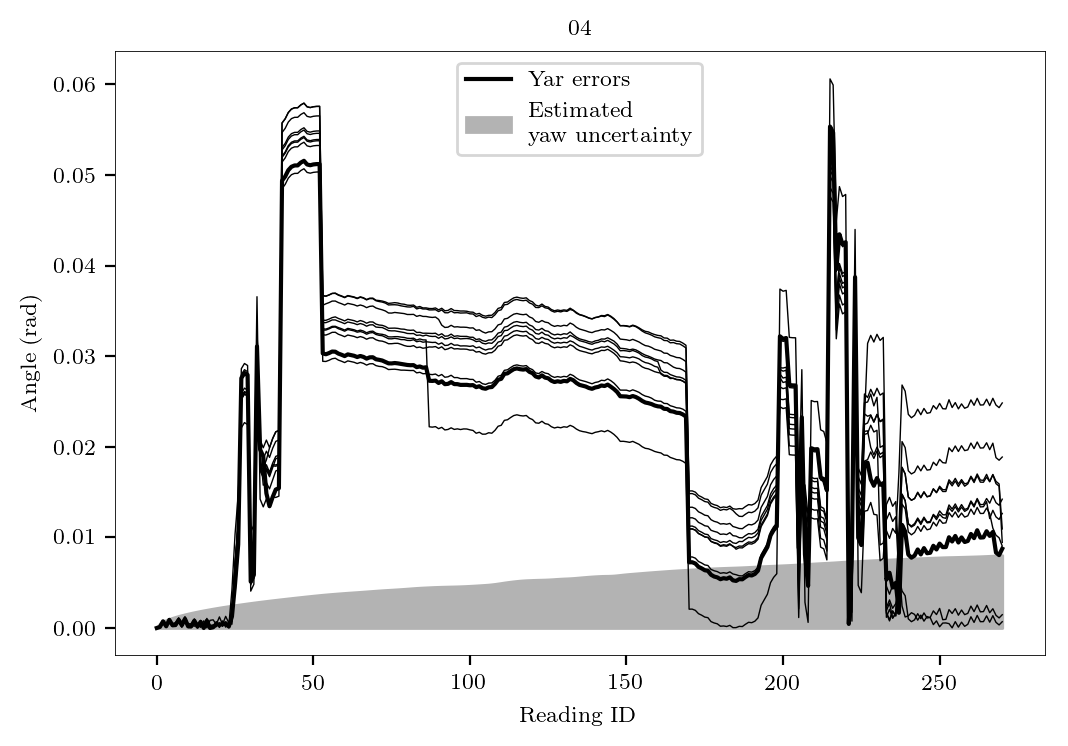

In [89]:
fig, ax = plt.subplots()
fig.set_dpi(200)

for e in errors[1:]:
    ax.plot(e, color='black', linewidth='0.5')
ax.plot(errors[0], color='black', label='Yar errors')

ax.fill_between(range(len(yaw_std)), [0.0] * len(yaw_std), 1*yaw_std, label='Estimated \n yaw uncertainty', color='0.7')
ax.set_xlabel('Reading ID')
ax.set_ylabel('Angle (rad)')
plt.legend()
plt.title(LOCATION)
#plt.tight_layout()
plt.savefig('/home/dlandry/yaw-error.png')
plt.show()

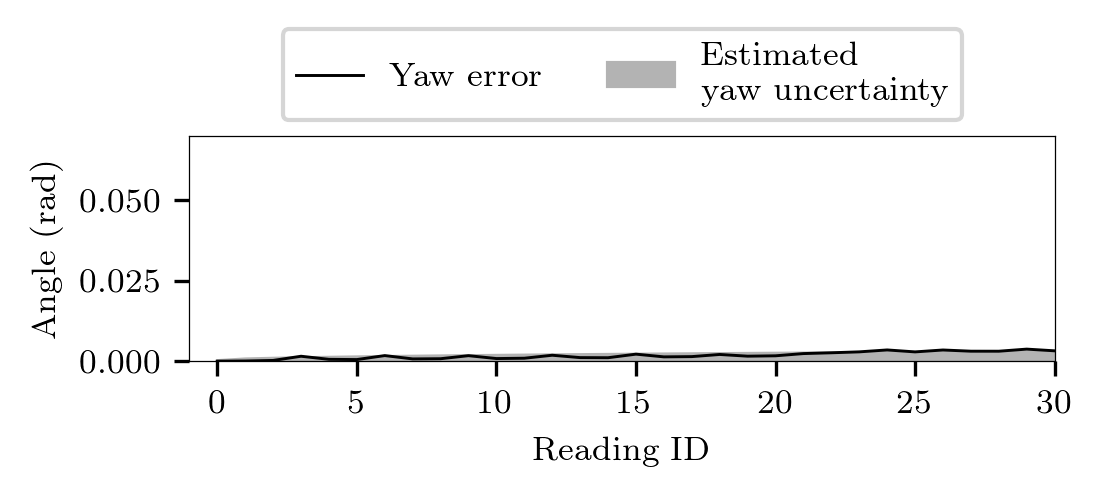

In [81]:
set_matplotlibrc()

fig, ax = plt.subplots()
fig.set_size_inches((3.413, 1.5))
fig.set_dpi(300)

#for x in errors:
#    ax.plot(range(len(errors)), errors, color='black', linewidth=0.8)

ax.plot(errors[0], color='black', linewidth='0.7', label='Yaw error')
#for e in errors[1:]:
#    ax.plot(e, color='black', linewidth='0.7')
#ax.plot(errors[0], color='black')

ax.fill_between(range(len(yaw_std)), [0.0] * len(yaw_std), 1*yaw_std, label='Estimated \n yaw uncertainty', color='0.7')
ax.set_xlabel('Reading ID')
ax.set_ylabel('Angle (rad)')
ax.set_ylim([0.0, 0.07])
ax.set_xlim((-1, 30))

plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.55))
#plt.tight_layout()
plt.subplots_adjust(top=0.75, bottom=0.25, right=0.97)
plt.savefig('/home/dlandry/yaw-error.pdf')
plt.show()